<font size="6"> **Statistical Risk Model** </font>

$$ \vec{r}(N,T) = \vec{\beta}(N,K) · \vec{f}(K,T) + \vec{s}(N,T)$$

* from $\vec{f}$ compute `factor covariance matrix`: $\vec{F}$
* from $\vec{s}$ compute `idiosyncratic covariance matrix` $\vec{S}$ and extract diagonal

Use  $\vec{\beta}$, $\vec{F}$ and $\vec{S}$ to estimate portfolio risk: $\sigma_{r_{p}}$

In [1]:
RND_SEED = 123
MODEL_VERSION = 'v01'
print('Model version: ', MODEL_VERSION)

Model version:  v01


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

In [4]:
import os
import pickle

import numpy as np
import scipy

from src import utils
from src.load_data import io_utils
from src.mle_quant_utils import risk_utils

In [38]:
cfg = utils.read_conf()

OUTPATH = os.path.join(io_utils.processed_path , cfg['output']['risk_factors']['folder'], MODEL_VERSION, "")
INFILE1 = cfg['output']['interim']['all_factors']
INFILE2 = cfg['output']['interim']['pricing']
print(os.path.isdir(OUTPATH))

True


In [39]:
MODEL_PATH = os.path.join(io_utils.models_path , cfg['output']['risk_factors']['folder'], MODEL_VERSION, "")

MODEL_NAME = cfg['output']['risk_factors']['model']
MODEL_METADATA = cfg['output']['risk_factors']['model_metadata']
print(os.path.isdir(MODEL_PATH))

True


In [7]:
split_col = cfg['models']['alpha_ml']['split_col']

# Load Data

In [8]:
splits = pd.read_csv(io_utils.interim_path + INFILE1, parse_dates=['date'], usecols=['date', 'asset', split_col])
splits['date'] = splits['date'].dt.tz_localize('utc')
splits.set_index(['date', 'asset'], inplace=True)
splits = splits[split_col]
splits.sample(3)

date                       asset
2013-10-21 00:00:00+00:00  ACN      train
2014-03-20 00:00:00+00:00  FMC      train
2014-12-01 00:00:00+00:00  GT       valid
Name: split, dtype: object

In [9]:
pricing = pd.read_csv(io_utils.interim_path + INFILE2, parse_dates=['date'])
pricing['date'] = pricing['date'].dt.tz_localize('utc')
pricing.set_index('date', inplace=True)

In [10]:
five_year_returns = pricing .pct_change()[1:].fillna(0)
pd.concat([five_year_returns.head(2), five_year_returns.tail(2)],axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,0.008197,0.002286,-0.003912,-0.012118,0.000000,-0.003901,0.000000,0.002150,-0.003916,0.015637,0.012086,-0.007853,-0.011404,-0.006239,0.004954,...,-0.005968,0.000630,0.007581,-0.020207,-0.004215,-0.005483,0.015861,0.002227,0.000000,-0.009296,0.027466,-0.003671,0.035401,0.017258,0.008916,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,0.004386,0.000428,0.008283,0.002576,-0.010916,-0.006665,-0.001547,0.001873,-0.012919,0.015766,-0.061948,0.001991,0.002362,0.003829,0.002054,...,0.021715,-0.005771,0.002744,-0.009536,0.004696,-0.001685,-0.006791,-0.006488,0.000000,-0.008862,0.011180,-0.008742,-0.000247,0.009920,-0.006336,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2016-01-04 00:00:00+00:00,-0.028282,-0.033988,0.011494,0.000855,-0.027512,-0.017741,-0.044067,-0.025551,-0.020971,-0.015919,-0.022909,-0.031289,-0.017573,-0.010176,-0.004646,0.001031,-0.014733,0.010547,-0.012041,-0.016097,-0.024851,-0.009484,-0.025085,-0.018065,-0.006080,...,-0.024718,0.005839,0.000191,-0.026661,0.008305,-0.017241,0.021014,0.002615,-0.002207,-0.016201,-0.005028,-0.024365,-0.006068,0.006944,-0.005859,-0.024767,-0.024922,-0.006276,-0.032711,-0.031051,-0.011520,-0.011489,-0.007604,-0.021614,-0.013564
2016-01-05 00:00:00+00:00,0.004058,-0.009541,-0.006830,-0.025054,-0.004169,0.014629,-0.000247,0.005207,0.004023,-0.007347,0.011150,0.002436,0.008611,0.001326,0.011859,0.008223,0.013894,0.013915,-0.001362,0.004099,0.003461,0.025460,0.016685,0.002724,-0.005544,...,-0.026243,-0.004309,0.010731,-0.000386,-0.021539,0.003824,0.003445,0.023748,-0.000658,-0.003962,0.002360,0.007906,0.018908,0.006447,0.010087,0.002098,0.014863,0.008511,0.020390,-0.001957,-0.000286,-0.002495,0.020820,-0.010853,0.015647


In [11]:
universe_tickers = five_year_returns.columns.drop_duplicates()

# Data Partition

In [12]:
valid_dates = splits[splits=='valid'].index.get_level_values(0)
valid_start = valid_dates[0].strftime('%Y-%m')
valid_end = valid_dates[-1].strftime('%Y-%m')
print(valid_start, valid_end)

2014-10 2015-05


In [13]:
test_dates = splits[splits=='test'].index.get_level_values(0)
test_start = test_dates[0].strftime('%Y-%m')
test_end = test_dates[-1].strftime('%Y-%m')
print(test_end)

2015-12


In [14]:
train_valid_idx = splits[(splits=='train') | (splits=='valid')].index.get_level_values(0).drop_duplicates()

In [15]:
pd.concat([five_year_returns.head(2), five_year_returns.tail(2)],axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,0.008197,0.002286,-0.003912,-0.012118,0.000000,-0.003901,0.000000,0.002150,-0.003916,0.015637,0.012086,-0.007853,-0.011404,-0.006239,0.004954,...,-0.005968,0.000630,0.007581,-0.020207,-0.004215,-0.005483,0.015861,0.002227,0.000000,-0.009296,0.027466,-0.003671,0.035401,0.017258,0.008916,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,0.004386,0.000428,0.008283,0.002576,-0.010916,-0.006665,-0.001547,0.001873,-0.012919,0.015766,-0.061948,0.001991,0.002362,0.003829,0.002054,...,0.021715,-0.005771,0.002744,-0.009536,0.004696,-0.001685,-0.006791,-0.006488,0.000000,-0.008862,0.011180,-0.008742,-0.000247,0.009920,-0.006336,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2016-01-04 00:00:00+00:00,-0.028282,-0.033988,0.011494,0.000855,-0.027512,-0.017741,-0.044067,-0.025551,-0.020971,-0.015919,-0.022909,-0.031289,-0.017573,-0.010176,-0.004646,0.001031,-0.014733,0.010547,-0.012041,-0.016097,-0.024851,-0.009484,-0.025085,-0.018065,-0.006080,...,-0.024718,0.005839,0.000191,-0.026661,0.008305,-0.017241,0.021014,0.002615,-0.002207,-0.016201,-0.005028,-0.024365,-0.006068,0.006944,-0.005859,-0.024767,-0.024922,-0.006276,-0.032711,-0.031051,-0.011520,-0.011489,-0.007604,-0.021614,-0.013564
2016-01-05 00:00:00+00:00,0.004058,-0.009541,-0.006830,-0.025054,-0.004169,0.014629,-0.000247,0.005207,0.004023,-0.007347,0.011150,0.002436,0.008611,0.001326,0.011859,0.008223,0.013894,0.013915,-0.001362,0.004099,0.003461,0.025460,0.016685,0.002724,-0.005544,...,-0.026243,-0.004309,0.010731,-0.000386,-0.021539,0.003824,0.003445,0.023748,-0.000658,-0.003962,0.002360,0.007906,0.018908,0.006447,0.010087,0.002098,0.014863,0.008511,0.020390,-0.001957,-0.000286,-0.002495,0.020820,-0.010853,0.015647


# Compute PCA
Create an statistical Risk model by running a Principal Components Analysis on 5 years returns data. The time span selected to compute this statistical model is a very important choice, but 5 years is an industry standard

In [16]:
five_year_returns.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.0,0.001994,0.004165,0.001648,-0.007127,-0.005818,0.008197,0.002286,-0.003912,-0.012118,0.000000,-0.003901,0.000000,0.002150,-0.003916,0.015637,0.012086,-0.007853,-0.011404,-0.006239,0.004954,...,-0.005968,0.000630,0.007581,-0.020207,-0.004215,-0.005483,0.015861,0.002227,0.0,-0.009296,0.027466,-0.003671,0.035401,0.017258,0.008916,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.0,0.012457,-0.000181,-0.010458,0.0
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.0,-0.005714,-0.008896,-0.008854,0.028714,0.002926,0.004386,0.000428,0.008283,0.002576,-0.010916,-0.006665,-0.001547,0.001873,-0.012919,0.015766,-0.061948,0.001991,0.002362,0.003829,0.002054,...,0.021715,-0.005771,0.002744,-0.009536,0.004696,-0.001685,-0.006791,-0.006488,0.0,-0.008862,0.011180,-0.008742,-0.000247,0.009920,-0.006336,0.000947,0.007814,-0.006081,0.010466,0.009733,0.0,0.001440,0.007784,-0.017945,0.0
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.0,0.009783,-0.002067,0.013717,0.000607,0.008753,0.003765,0.004560,0.003201,-0.001591,0.012111,0.004473,0.013128,0.014919,0.009980,-0.012899,0.028750,-0.028865,0.001316,-0.001730,-0.000820,...,-0.002924,-0.008514,0.002737,0.006419,-0.001260,-0.003025,0.025025,0.010439,0.0,0.011571,0.015874,0.003045,-0.013569,0.013963,-0.003412,0.001314,0.010179,0.007442,0.007351,0.006116,0.0,-0.006470,0.035676,0.007467,0.0
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.0,-0.005979,-0.001011,0.022969,0.017950,0.000257,0.010840,0.013080,0.021939,-0.006618,0.003571,0.000868,-0.015207,0.003348,0.026393,-0.012893,-0.010841,0.012636,0.013327,-0.002088,0.010462,...,0.009051,0.011958,0.009376,0.019445,0.021649,0.008890,0.020494,0.010309,0.0,-0.004680,0.019882,-0.006742,-0.002644,0.017541,0.002582,0.004986,0.015666,0.011763,0.027182,0.004386,0.0,0.002631,0.014741,-0.011903,0.0
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.0,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,0.020594,-0.009634,-0.018070,0.013570,-0.009856,-0.007806,-0.000822,-0.000300,-0.001225,0.004419,-0.020724,-0.003637,-0.007481,-0.005165,0.022737,...,0.010674,-0.006066,-0.002529,-0.003777,-0.024749,0.008777,0.024328,-0.001085,0.0,-0.002090,-0.009777,0.001350,-0.000514,0.014809,-0.003807,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.0,-0.005084,-0.004665,-0.009178,0.0


In [17]:
X_train = five_year_returns[:valid_end]
X_test = five_year_returns[test_start:]

In [18]:
n_components =  [3, 5, 10, 20, 50]
k_folds = 3
exp_var = risk_utils.gridsearch_pca_expvar(X_train, n_components=n_components, k_folds=k_folds, random_state = RND_SEED)

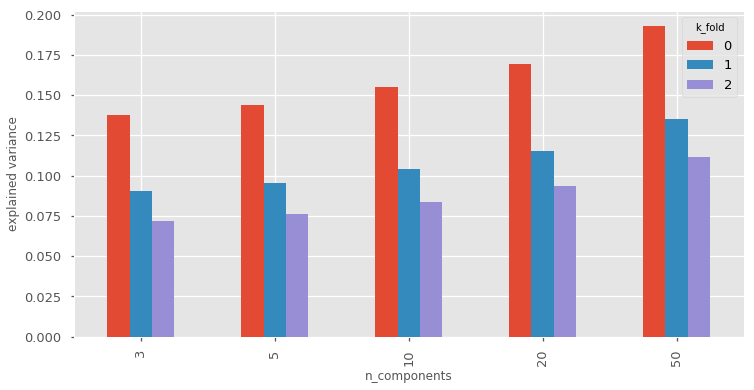

In [19]:
exp_var.plot.bar(label='folds', figsize=(12,6))
plt.xlabel('n_components')
plt.ylabel('explained variance')
plt.legend(title='k_fold')
plt.show()

In [20]:
num_factor_exposures = 20

pca = risk_utils.fit_pca(X_train, num_factor_exposures, 'full', RND_SEED)

pca.components_.shape

(20, 490)

Let's also look at the PCA's percent of variance explained by each factor

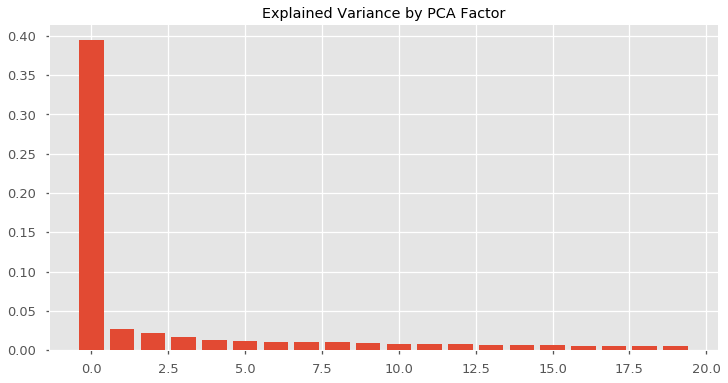

In [21]:
fig = plt.figure(figsize=(12, 6))

plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_)
plt.title("Explained Variance by PCA Factor")
plt.show()

The first factor dominates, this factor is defined by a set of loadings (weights applied to each input return), although, the precise definition of each factor in a latent model is unknown

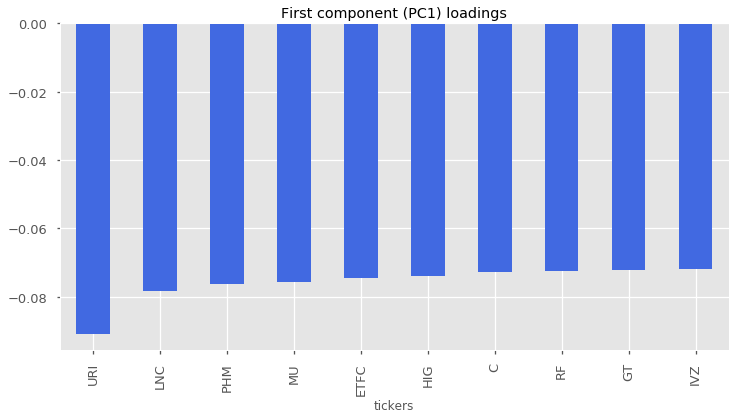

In [22]:
loadings = pd.Series(index= universe_tickers, data=pca.components_[0], name='PC1')
loadings.sort_values()[:10].plot.bar(color='royalblue', title='First component (PC1) loadings', figsize=(12, 6))
plt.xlabel('tickers')
plt.show()

# Factor Betas

$$ \vec{\beta}(N,K) $$
Implement `factor_betas` to get the factor betas from the PCA model.

In [23]:
risk_model = {}
risk_model_test = {}

risk_model['factor_betas'] = risk_utils.factor_betas(pca, X_train.columns.values, np.arange(num_factor_exposures))
risk_model_test['factor_betas'] = risk_model['factor_betas'].copy()

risk_model['factor_betas'][:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A,-0.042628,0.014983,0.012869,0.003801,-0.022948,0.010030,-0.004048,-0.006718,-0.034471,0.024555,-0.017108,0.018875,0.025266,0.014909,-0.026406,0.033897,-0.029173,-0.030546,-0.026341,-0.012199
AAL,-0.060402,0.258601,-0.037516,0.144527,0.296615,-0.080756,0.113555,-0.024766,-0.161712,-0.035469,0.043421,0.100238,-0.014771,-0.026967,0.015362,0.025396,-0.013467,-0.056342,0.067339,0.092211


# Factor Returns
$$ \vec{f}(T,K) $$
Implement `factor_returns` to get the factor returns from the PCA model using the returns data.

In [24]:
risk_model['factor_returns'] = risk_utils.factor_returns(
    pca,
    X_train,
    X_train.index,
    np.arange(num_factor_exposures))
risk_model['factor_returns'].index.name = 'date'

risk_model['factor_returns'][:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2011-01-07 00:00:00+00:00,0.002368,-0.017349,-0.014571,-0.006355,0.078109,-0.053794,0.024499,-0.056598,0.005596,-0.033146,-0.008397,-0.080584,0.047754,-0.019034,-0.031117,0.025826,-0.023411,-0.021086,-0.015933,-0.013473
2011-01-10 00:00:00+00:00,-0.000887,-0.023872,-0.072516,-0.001991,-0.026355,-0.062751,0.008012,0.060594,-0.016167,-0.033728,0.064455,0.016234,-0.007310,-0.003652,-0.028043,-0.006903,0.027921,0.005312,0.010000,0.018064


In [25]:
risk_model_test['factor_returns'] = risk_utils.factor_returns(
    pca,
    X_test,
    X_test.index,
    np.arange(num_factor_exposures))
risk_model_test['factor_returns'].index.name = 'date'
risk_model_test['factor_returns'][:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00+00:00,-0.231498,0.087009,-0.035185,-0.056721,0.006649,-0.014624,0.015049,-0.015601,-0.034371,0.031523,0.000828,-0.002096,0.017049,0.021042,0.019484,-0.058597,0.001738,-0.028662,0.026607,-0.074468
2015-05-04 00:00:00+00:00,-0.054719,0.007882,0.043880,0.020466,-0.049734,0.038801,-0.013299,0.006079,0.007780,-0.013627,0.000676,-0.017142,-0.028415,-0.011957,-0.016032,0.018925,-0.009592,0.018181,0.010830,-0.002648


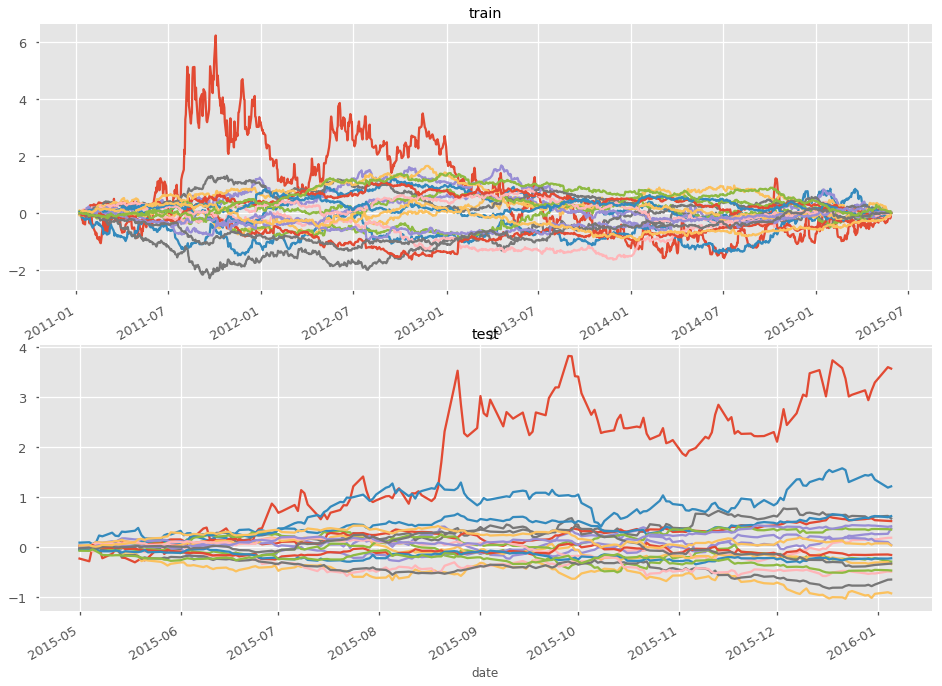

In [26]:
fig, axs = plt.subplots(2,1, figsize=(16, 12))
ax1, ax2 = axs
risk_model['factor_returns'].cumsum().plot(ax=ax1, title='train', legend=None)
risk_model_test['factor_returns'].cumsum().plot(ax=ax2, title='test', legend=None)
plt.show()

Recall that:



In this exersice, factor betas are assumed to be constant for the entire testing dataset, in a more refined scheme, factor betas may be updated daily. In hit scheme, is important to consider a time lag consisting:

Run simulation on day t (assumming a delay of 2 trading days):
* Compute daily factor betas:
$\beta_{i,j,t}$ -> run PCA (or any other method) from t-tau to t-1
* Compute factor returns
$$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$$
where $i=1...N$ (N assets), and $j=1...k$ (k factors).   
where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. 

In [27]:
factor_returns_test, factor_returns_expvar_test = risk_utils.compute_static_factor_returns(X_test, risk_model_test['factor_betas'])
factor_returns_test[0:2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
date,,,,,,,,,,,,,,,,,,,,
2015-05-01 00:00:00+00:00,-0.247383,0.0922262,-0.0354954,-0.0619624,0.00731618,-0.0131741,0.0129828,-0.0158566,-0.0352023,0.0316504,0.000336804,-0.00118795,0.0155665,0.0224999,0.0202206,-0.0593176,0.000436518,-0.0280153,0.0272384,-0.0753836
2015-05-04 00:00:00+00:00,-0.0706037,0.0130992,0.0435694,0.0152248,-0.049067,0.0402508,-0.0153655,0.00582366,0.00694788,-0.0134997,0.000184609,-0.0162333,-0.0298968,-0.0104986,-0.0152951,0.0182046,-0.0108934,0.0188279,0.0114606,-0.00356342


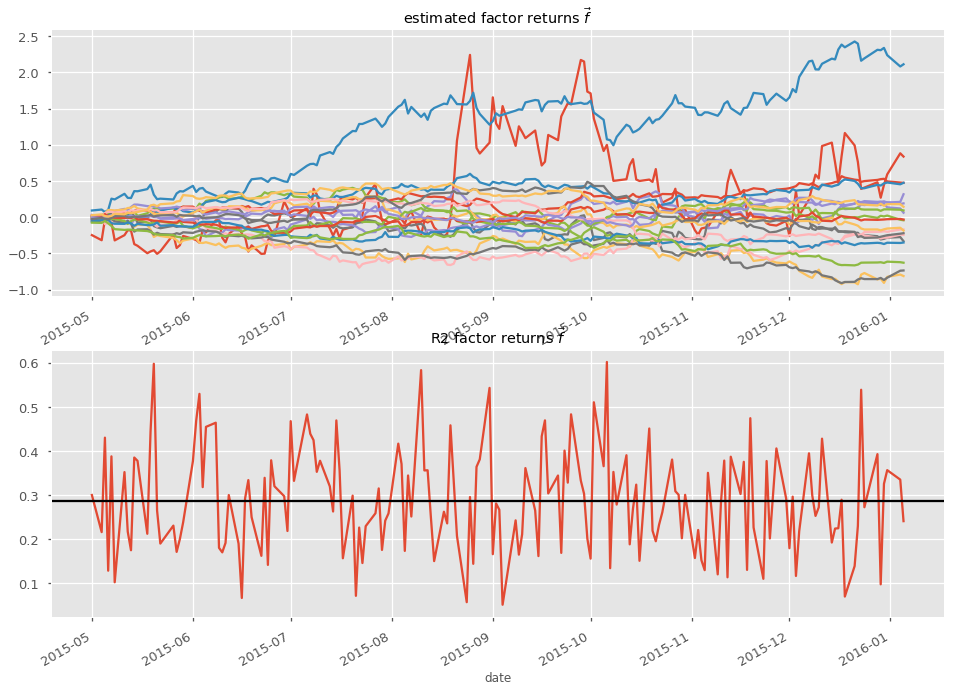

In [28]:
fig, axs = plt.subplots(2,1, figsize=(16, 12))
ax1, ax2 = axs

factor_returns_test.cumsum().plot(ax=ax1, title=r'estimated factor returns $\vec{f}$', legend=None)
factor_returns_expvar_test.plot(ax=ax2, title=r'R2 factor returns $\vec{f}$')
ax2.axhline(y=factor_returns_expvar_test.mean(), color='black')
plt.show()

# Covariance Matrix Estimation

## Factor Covariance Matrix
$$ \vec{F}(K,K) $$
Implement `factor_cov_matrix` to get the factor covariance matrix.

In [29]:
ann_factor = 252
risk_model['factor_cov_matrix'] = risk_utils.factor_cov_matrix(risk_model['factor_returns'], ann_factor)
risk_model_test['factor_cov_matrix'] = risk_utils.factor_cov_matrix(risk_model_test['factor_returns'], ann_factor)

print(risk_model['factor_cov_matrix'].shape)
risk_model['factor_cov_matrix'][:2]

(20, 20)


array([[13.97417511,  0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        ,  0.        , -0.        , -0.        ],
       [ 0.        ,  0.97156884,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [30]:
risk_model['factor_var_vector'] = risk_utils.factor_var_vector(risk_model['factor_returns'], risk_model['factor_cov_matrix'])
risk_model_test['factor_var_vector'] = risk_utils.factor_var_vector( risk_model_test['factor_returns'], risk_model_test['factor_cov_matrix'])

## Idiosyncratic Variance Matrix
$$ \vec{S}(N,N) $$
Implement `idiosyncratic_var_matrix` to get the idiosyncratic variance matrix.

In [31]:
idiosyncratic_var_matrix = risk_utils.idiosyncratic_var_matrix(X_train, risk_model['factor_returns'], risk_model['factor_betas'], ann_factor)
idiosyncratic_var_matrix_test = risk_utils.idiosyncratic_var_matrix(X_test, risk_model_test['factor_returns'], risk_model_test['factor_betas'], ann_factor)

idiosyncratic_var_matrix[:2]

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
A,0.023605,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAL,0.000000,0.05303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
idiosyncratic_var_matrix.shape

(490, 490)

In [33]:
risk_model['idiosyncratic_var_vector'] = risk_utils.idiosyncratic_var_vector(X_train, idiosyncratic_var_matrix)
risk_model_test['idiosyncratic_var_vector'] = risk_utils.idiosyncratic_var_vector(X_test, idiosyncratic_var_matrix_test)


risk_model['idiosyncratic_var_vector'][:2]

,0
A,0.023605
AAL,0.053030


# Predict using the Risk Model
Using the data we calculated in the risk model, implement `predict_portfolio_risk` to predict the portfolio risk using the formula $ \sigma_{r_{p}} = \sqrt{X^{T}(BFB^{T} + S)X} $ where:
- $ X $ is the portfolio weights
- $ B $ is the factor betas
- $ F $ is the factor covariance matrix
- $ S $ is the idiosyncratic variance matrix

Let's see what the portfolio risk would be if we had even weights across all stocks.

In [34]:
all_weights = pd.DataFrame(np.repeat(1/len(universe_tickers), len(universe_tickers)), universe_tickers)

risk_utils.predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    idiosyncratic_var_matrix,
    all_weights)

0.159473730783234

# Write Risk Model

In [40]:
metadata = {
    'train_start_dt': X_train.index[0].strftime('%Y-%m-%d'),
    'factor_start_dt': test_dates[0].strftime('%Y-%m-%d'),
    'factor_end_dt': test_dates[-1].strftime('%Y-%m-%d'),
    'model': 'pca',
    'kind': 'static'}

In [43]:
with open(MODEL_PATH + MODEL_NAME, 'wb') as file:
    pickle.dump(pca, file)
    
with open(MODEL_PATH + MODEL_METADATA, 'wb') as file:
    pickle.dump(metadata, file)

In [44]:
risk_model_test.keys()

dict_keys(['factor_returns', 'factor_var_vector', 'factor_betas', 'factor_cov_matrix', 'idiosyncratic_var_vector'])

In [45]:
for key, data in risk_model_test.items():
    path = OUTPATH + key + ".csv"
    if isinstance(data, pd.Series) or isinstance(data, pd.DataFrame):
        print("Writing: {}".format(key))
        data.to_csv(path)

Writing: factor_returns
Writing: factor_var_vector
Writing: factor_betas
Writing: idiosyncratic_var_vector
